In [ ]:
import os.path
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os

In [ ]:
def prepare_charts(_df_org, _clustername):
    df_org = _df_org
    clustercolumn = _clustername
    yrs = df_org['Year'].unique()
    yrs.sort()
    clusters = df_org[clustercolumn].unique()
    clusters.sort()
    df_org.rename(columns={'RAIL_FLAG': 'Mode'}, inplace=True)
    modes = df_org['Mode'].unique()
    modes.sort()

    chartcols = ['UPT_ADJ_VRM_ADJ_log_FAC_cumsum', 'UPT_ADJ_FARE_per_UPT_2018_log_FAC_cumsum',
                 'UPT_ADJ_POP_EMP_log_FAC_cumsum', 'UPT_ADJ_GAS_PRICE_2018_log_FAC_cumsum',
                 'UPT_ADJ_TOTAL_MED_INC_INDIV_2018_log_FAC_cumsum',
                 'UPT_ADJ_Tot_NonUSA_POP_pct_FAC_cumsum', 'UPT_ADJ_PCT_HH_NO_VEH_FAC_cumsum',
                 'UPT_ADJ_TSD_POP_PCT_FAC_cumsum', 'UPT_ADJ_JTW_HOME_PCT_FAC_cumsum',
                 'UPT_ADJ_RAIL_COMPETITION_FAC_cumsum', 'UPT_ADJ_YEARS_SINCE_TNC_BUS_FAC_cumsum',
                 'UPT_ADJ_YEARS_SINCE_TNC_RAIL_FAC_cumsum', 'UPT_ADJ_BIKE_SHARE_BUS_FAC_cumsum',
                 'UPT_ADJ_scooter_flag_BUS_FAC_cumsum', 'UPT_ADJ_BIKE_SHARE_RAIL_FAC_cumsum']

    for cluster in clusters:
        df_fltr = df_org[df_org[clustercolumn] == cluster]
        # Print the cluster
        col_index = df_fltr.columns.get_loc(clustercolumn)
        cluster_code = str(df_fltr.iloc[0, col_index])
        print('Cluster Code:' + str(cluster_code))
        df_fltr['Year'] = pd.to_datetime(df_fltr['Year'].astype(str), format='%Y')
        df_fltr_mod = df_fltr.set_index(pd.DatetimeIndex(df_fltr['Year']).year)

        # Initialize the figure
        plt.style.use('seaborn-darkgrid')
        # create a color palette
        palette = plt.get_cmap('Set1')
        # # multiple line plot
        # num = 0
        x = 1
        fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(5, 5), constrained_layout=True)

        for mode in modes:
            if mode == 0:
                mode_name = "BUS"
            else:
                mode_name = "RAIL"
            df_fltr_mode = df_fltr_mod[df_fltr_mod.Mode == mode]
            col = 0
            row = 0
            transparency = 0.3
            num = 0
            for chartcol in chartcols:
                df_fltr_mode.groupby('Mode').plot(x='Year', y=str(chartcol),
                                                  label='Hypothezized rdrship if no changes in ' + str(chartcol),
                                                  ax=ax[row][col], legend=True)
                df_fltr_mode.groupby('Mode').plot(x='Year', y='UPT_ADJ', label='Observed Rdrship', ax=ax[row][col],
                                                  legend=True, color='black', linewidth=2.4)
                # Paint the area
                ax[row][col].fill_between(df_fltr_mode['Year'].values, df_fltr_mode[chartcol].values,
                                          df_fltr_mode['UPT_ADJ'].values,
                                          where=df_fltr_mode['UPT_ADJ'].values > df_fltr_mode[chartcol].values,
                                          facecolor='red', interpolate=True, alpha=transparency)
                ax[row][col].fill_between(df_fltr_mode['Year'].values, df_fltr_mode[chartcol].values,
                                          df_fltr_mode['UPT_ADJ'].values,
                                          where=df_fltr_mode['UPT_ADJ'].values <= df_fltr_mode[chartcol].values,
                                          facecolor='green', interpolate=True, alpha=transparency)
                ax[row][col].set(xlabel="Years", ylabel='Ridership')
                ax[row][col].legend(loc='best')
                ax[row][col].set_autoscaley_on(False)
                try:
                    ax[row][col].grid(True)
                    ax[row][col].margins(0.20)
                    ax[row][col].set_ylim([0, max(df_fltr_mode[['UPT_ADJ', chartcol]].values.max(1))])
                except ValueError:
                    pass
                num +=1
                if num>4:
                    row=0
                    col+=1
                else:
                    row +=1
        

In [ ]:
def create_upt_fac_total_apta4_cluster(_filename, _clustervalue):
    # get the abs path of the directory of the code/script
    # Factors and Ridership Data\ code
    current_dir = pathlib.Path(__file__).parent.absolute()
    folder_name = chart_name = _filename.split('.')[0]
    # Change the directory
    # \Script Outputs \ Cluster_wise_summation_files
    # print("current directory at get_cluster_file ",current_dir)
    current_dir = current_dir.parents[0] / 'Model Estimation' / 'Est6'
    os.chdir(str(current_dir))
    # print("set directory at get_cluster_file ", current_dir)
    df_org = pd.read_csv(_filename)
    # create cumulative column and update the column
    # create new columns
    col_name = ['VRM_ADJ_log_FAC', 'FARE_per_UPT_2018_log_FAC', 'POP_EMP_log_FAC', 'GAS_PRICE_2018_log_FAC',
                'TOTAL_MED_INC_INDIV_2018_log_FAC', 'Tot_NonUSA_POP_pct_FAC', 'PCT_HH_NO_VEH_FAC', 'TSD_POP_PCT_FAC',
                'JTW_HOME_PCT_FAC', 'RAIL_COMPETITION_FAC', 'YEARS_SINCE_TNC_BUS_FAC', 'YEARS_SINCE_TNC_RAIL_FAC',
                'BIKE_SHARE_BUS_FAC', 'scooter_flag_BUS_FAC', 'BIKE_SHARE_RAIL_FAC', 'Total_FAC']
    cum_col = []
    col_UPT_ADJ = ['UPT_ADJ']

    for col in col_name:
        df_org[str(col) + '_cumsum'] = df_org[col]
        cum_col.append(str(col) + '_cumsum')

    cluster_values = _clustervalue

    # # for each cluster_id get the cumulative addition starting from 2002-->2018
    # os.chdir(output_folder)
    for col in cum_col:
        df_org[col] = df_org.groupby([cluster_values, 'RAIL_FLAG'])[col].cumsum()

    # # create a new column which is diff between UPT_ADJ - CUMSUM colmn
    for col in cum_col:
        df_org['UPT_ADJ_' + str(col)] = df_org['UPT_ADJ'] - df_org[col]

        # save the cumulative file as UPT_filename.csv
    df_org.to_csv("UPT_" + folder_name + '.csv')
    print("Success")

    prepare_charts(df_org, cluster_values)

In [ ]:
def main():
    # Pass on the cluster_file and cluster_column
    create_upt_fac_total_apta4_cluster("FAC_totals_APTA4_CLUSTERS.csv", "CLUSTER_APTA4")

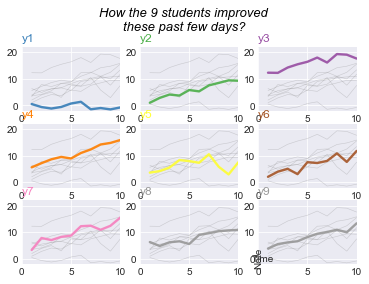

In [3]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': range(1,11), 'y1': np.random.randn(10), 'y2': np.random.randn(10)+range(1,11), 'y3': np.random.randn(10)+range(11,21), 'y4': np.random.randn(10)+range(6,16), 'y5': np.random.randn(10)+range(4,14)+(0,0,0,0,0,0,0,-3,-8,-6), 'y6': np.random.randn(10)+range(2,12), 'y7': np.random.randn(10)+range(5,15), 'y8': np.random.randn(10)+range(4,14), 'y9': np.random.randn(10)+range(4,14) })
 
# Initialize the figure
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
 
    # plot every groups, but discreet
    for v in df.drop('x', axis=1):
        plt.plot(df['x'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # Same limits for everybody!
    plt.xlim(0,10)
    plt.ylim(-2,22)
 
    # Not ticks everywhere
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
 
# general title
plt.suptitle("How the 9 students improved\nthese past few days?", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
 
# Axis title
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')

plt.show()